In [1]:
import math
import random
import numpy as np
import scipy.io as sio
import scipy.optimize as opt
from matplotlib import pyplot as plt

Neurons are basically computational units that take inputs and channel them to outputs using hidden layer.
Hidden layer will use a sigmoid function as an **activation function**.

With one hidden layer, vectorized implementation of neural networks might look like this:
$$
\quad
\begin{bmatrix}
x_0 \\
x_1 \\
x_2 \\
x_3
\end{bmatrix} \rightarrow
\begin{bmatrix}
a_1^{2} \\
a_2^{2} \\
a_3^{2}
\end{bmatrix} \rightarrow
h(x)
$$

Each *a* represent an activation unit.
$$
a_i^{(j)} \text{- "activation" of unit i in layer j}
\\
\Theta^{(j)} \text{- matrix of "weights"}
$$

Each activation node *a* can be calculated in the following way:
\begin{align*} a_1^{(2)} = g(\Theta_{10}^{(1)}x_0 + \Theta_{11}^{(1)}x_1 + \Theta_{12}^{(1)}x_2 + \Theta_{13}^{(1)}x_3) \newline a_2^{(2)} = g(\Theta_{20}^{(1)}x_0 + \Theta_{21}^{(1)}x_1 + \Theta_{22}^{(1)}x_2 + \Theta_{23}^{(1)}x_3) \newline a_3^{(2)} = g(\Theta_{30}^{(1)}x_0 + \Theta_{31}^{(1)}x_1 + \Theta_{32}^{(1)}x_2 + \Theta_{33}^{(1)}x_3) \newline h_\Theta(x) = a_1^{(3)} = g(\Theta_{10}^{(2)}a_0^{(2)} + \Theta_{11}^{(2)}a_1^{(2)} + \Theta_{12}^{(2)}a_2^{(2)} + \Theta_{13}^{(2)}a_3^{(2)}) \newline \end{align*}

## Activation function

Activation function is just a sigmoid function and can be easily calculated using Python:

In [2]:
def sigmoid(z):
    return 1 / (1 + math.e ** (-z))

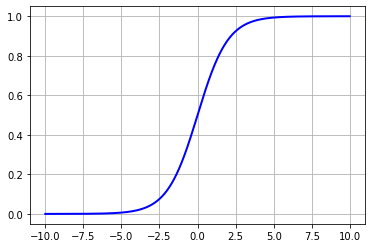

In [3]:
def plot_sigmoid():
    rand_dataset = np.arange(-10., 10., 0.01)
    calculated_dataset = [sigmoid(x) for x in rand_dataset]
    plt.plot(rand_dataset, calculated_dataset, color='b', lw=2)
    plt.gca().grid()

plot_sigmoid()

## Reading data

Andrew's course provides a *.mat file that contains the X and Y values.

X is a matrix of size 5000 x 400 - in other words it contains 5000 'images' of 400 pixels each - i.e. size of each picture is 20 x 20 pixels.

Y is a vector of size 5000 - it contains a single value that represent the actual number displayed in the image. 1 for '1'. 2 for '2' etc. it is just a 0 that is saved in the vector as '10'.

In [4]:
def load_mat(filename, col_1, col_2):
    mat_data = sio.loadmat(filename)
    return mat_data[col_1], mat_data[col_2]

X, Y = load_mat('./ex4data1.mat', 'X', 'y')

## Reading weights

During the course, there is also a *.mat file provided with weights - i.e. parameters Theta1 and Theta2 that we can use.
These are pre-trained solution for our model so we can immediately use those for computations.

In [5]:
theta_1, theta_2 = load_mat('./ex4weights.mat', 'Theta1', 'Theta2')
# Parameters 'unrolled' into single vector
nn_params = np.concatenate((theta_1.flatten(), theta_2.flatten())).reshape(10285, 1)

## Visualizing data

To better understand how the images look like, let's visualize them by selecting random 25 images.

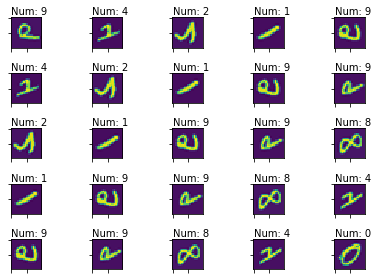

In [6]:
def get_random_img_with_label(x_matrix, y_vector):
    size = np.size(x_matrix, 0)
    rand_img_loc = random.randint(0, size)
    return x_matrix[rand_img_loc].reshape(20, 20), y_vector[rand_img_loc, 0]

def plot_images(images):
    f, axarr = plt.subplots(5, 5)
    for i in range(0, 5):
        for j in range(0, 5):
            img, label = images[i + j]
            axarr[i, j].set_xticklabels([])
            axarr[i, j].set_yticklabels([])
            axarr[i, j].imshow(img)
            axarr[i, j].text(0, -2, f"Num: {0 if label == 10 else label}")
    f.tight_layout()

images = [get_random_img_with_label(X, Y) for x in range(0, 25)]
plot_images(images)

## Gradient of sigmoid function

In [7]:
def sigmoid_gradient(z):
    return sigmoid(z) * (1 - sigmoid(z))

## Cost function

In [ ]:
def nn_cost_function(nn_params,
                     input_layer_size,
                     hidden_layer_size,
                     num_labels,
                     X,
                     y,
                     LAMBDA):
    theta_1 = (nn_params[0: hidden_layer_size * (input_layer_size + 1)]).reshape(
        (hidden_layer_size, input_layer_size + 1))
    theta_2 = (nn_params[hidden_layer_size * (input_layer_size + 1):]).reshape((num_labels, hidden_layer_size + 1))
    m = np.size(X, 0)
    j = 0
    # Input layer calculations
    a_1 = np.append(np.ones((np.shape(X)[0], 1)), X, axis=1)
    z_2 = a_1 @ theta_1.transpose()
    # Hidden layer calculations
    a_2 = sigmoid(z_2)
    # Add bias input node
    a_2 = np.append(np.ones((np.size(a_2, 0), 1)), a_2, 1)
    z_3 = a_2 @ theta_2.transpose()
    # Output layer calculations
    a_3 = sigmoid(z_3)
    I = np.eye(num_labels)
    # Work-around - trained dataset assumes '0' is represented by 10
    # First column will be omitted in later calculations
    Y = np.zeros((m, num_labels + 1))
    for i in range(0, m):
        Y[i, 1:] = I[y[i] - 1, :]
    j = (1 / m * (np.sum(-Y[:, 1:] * np.log(a_3) - (1 - Y[:, 1:]) * np.log(1 - a_3)))) + (
        (LAMBDA / (2 * m)) * ((np.sum(np.power(theta_1[:, 1:], 2))) + (np.sum(np.power(theta_2[:, 1:], 2)))))

    # Backpropagation
    for t in range(1, m):
        a_1 = np.append(np.ones((np.shape(X)[0], 1)), X, axis=1)
        z_2 = a_1 @ theta_1.transpose()
        a_2 = sigmoid(z_2)
        a_2 = np.append(np.ones((np.size(a_2, 0), 1)), a_2, 1)
        z_3 = a_2 @ theta_2.transpose()
        a_3 = sigmoid(z_3)

        sigmas_3 = a_3 - Y[:, 1:]
        sigmas_2 = sigmas_3 @ theta_2 * np.concatenate((np.ones(((np.shape(z_2)[0]), 1)), sigmoid_gradient(z_2)), 1)
        delta_1 = ((a_1.transpose() @ sigmas_2).transpose())[1:]
        delta_2 = ((a_2.transpose() @ sigmas_3).transpose())
        theta_1_grad = 1 / m * delta_1
        theta_2_grad = 1 / m * delta_2
        grad_unrolled = np.concatenate((theta_1_grad.ravel(), theta_2_grad.ravel()))
    return j, grad_unrolled


theta_1, theta_2 = load_mat('./ex4weights.mat', 'Theta1', 'Theta2')
X, y = load_mat('./ex4data1.mat', 'X', 'y')
nn_params = np.concatenate((theta_1.flatten(), theta_2.flatten())).reshape(10285, 1)
INPUT_LAYER_SIZE = 400
HIDDEN_LAYER_SIZE = 25
NUM_OF_LABELS = 10
LAMBDA = 0


cost, grad = nn_cost_function(nn_params, INPUT_LAYER_SIZE, HIDDEN_LAYER_SIZE, NUM_OF_LABELS, X, y, LAMBDA)
print(cost)